In [24]:
import warnings
import random

import numpy as np
import pandas as pd
import itertools
import holidays
from shapely import wkt
from tqdm import tqdm


warnings.filterwarnings("ignore")

In [25]:
def optimize_memory(df: pd.DataFrame) -> pd.DataFrame:
    start_size = df.memory_usage().sum() / 1024 ** 2

    for column in df.columns:
        column_type = df[column].dtype

        if column_type == object:
            df[column] = df[column].astype("category")
            continue

        min = df[column].min()
        max = df[column].max()
        if str(column_type)[:3] == "int":
            if min > np.iinfo(np.int8).min and max < np.iinfo(np.int8).max:
                df[column] = df[column].astype(np.int8)
            elif min > np.iinfo(np.int16).min and max < np.iinfo(np.int16).max:
                df[column] = df[column].astype(np.int16)
            elif min > np.iinfo(np.int32).min and max < np.iinfo(np.int32).max:
                df[column] = df[column].astype(np.int32)
            else:
                df[column] = df[column].astype(np.int64)
            continue

        # Don't touch floats!

    end_size = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage {:.2f} MB -> {:.2f} MB (-{:.1f}%)".format(
        start_size,
        end_size,
        100 * (start_size - end_size) / start_size)
    )
    return df

In [26]:
train_df = optimize_memory(pd.read_csv("data/source/train_data.csv"))

Memory usage 780.63 MB -> 325.57 MB (-58.3%)


In [27]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


# Preprocessing

## Initial dataset
- timestamp – временная метка публикации с точностью до часа
- lon, lat – координаты геопозиции с округлением до полигона 250х250 метров (географические долгота и широта, соответственно)
- likescount – количество отметок «лайк» у публикации
- commentscount – количество комментариев у публикации
- symbols_cnt – общее количество символов в публикации
- words_cnt – количество слов (осмысленных, не считая спецсимволов и прочую метаинформацию)
- hashtags_cnt – количество хештегов
- mentions_cnt – количество упоминаний других пользователей
- links_cnt – количество ссылок
- emoji_cnt – количество эмодзи

In [28]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [29]:
train_df.shape

(8526526, 12)

# Convert Point ID to simple ID

In [30]:
points_df = train_df[["point"]].groupby(["point"], as_index=False).first().reset_index()
points_df.head()

,index,point
0,0,0101000020E61000000000000000000000000000000000...
1,1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...
2,2,0101000020E610000002BF48199F3F3E400A41C338F1F6...
3,3,0101000020E610000002BF48199F3F3E400A721DB144FC...
4,4,0101000020E610000002BF48199F3F3E400B9A5B330603...


In [31]:
points_df.shape

(7041, 2)

In [32]:
points_df.columns = ["new_point", "initial_point"]

In [33]:
points_df

,new_point,initial_point
0,0,0101000020E61000000000000000000000000000000000...
1,1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...
2,2,0101000020E610000002BF48199F3F3E400A41C338F1F6...
3,3,0101000020E610000002BF48199F3F3E400A721DB144FC...
4,4,0101000020E610000002BF48199F3F3E400B9A5B330603...
...,...,...
7036,7036,0101000020E6100000FF9D4C0EC3853E406E4CE6811AEA...
7037,7037,0101000020E6100000FF9D4C0EC3853E408481D0E8E0EF...
7038,7038,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...
7039,7039,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...


In [34]:
points_df.to_csv("./data/points_df.csv", index=None)

In [35]:
train_df = train_df.merge(
    points_df, how="left", left_on="point", right_on="initial_point"
)

In [37]:
train_df.drop(columns=["point", "initial_point"], inplace=True)

In [40]:
train_df.rename(columns={"new_point": "point"}, inplace=True)

In [42]:
train_df = optimize_memory(train_df)

Memory usage 439.10 MB -> 390.31 MB (-11.1%)


In [43]:
print(train_df.shape)
train_df.head()

(8526526, 12)


,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,6037
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,2362
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,4343
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,4354
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,1027


# Add time-based features

# Create calendar

In [45]:
russia_holidays = holidays.RU()

In [46]:
russia_holidays

holidays.country_holidays('RU')

In [47]:
calendar_df = pd.date_range(
    "2019-01-01T00:00:00", "2020-02-29T23:00:00", freq="1H"
).to_frame(index=False, name="datetime")

In [48]:
calendar_df.head()

,datetime
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00


In [49]:
calendar_df.shape

(10200, 1)

In [50]:
calendar_df["time_id"] = calendar_df.index
calendar_df["timestamp"] = calendar_df["datetime"].astype(np.int64) // 10**9

calendar_df["year"] = calendar_df["datetime"].dt.year
calendar_df["month"] = calendar_df["datetime"].dt.month
calendar_df["day"] = calendar_df["datetime"].dt.day
calendar_df["weekday"] = calendar_df["datetime"].dt.weekday
calendar_df["hour"] = calendar_df["datetime"].dt.hour

calendar_df["weekend"] = calendar_df["datetime"].dt.weekday // 5 # ones for two last weekday
calendar_df["holidays"] = calendar_df["datetime"].apply(
    lambda x: int(x in russia_holidays)
)

In [51]:
calendar_df

,datetime,time_id,timestamp,year,month,day,weekday,hour,weekend,holidays
0,2019-01-01 00:00:00,0,1546300800,2019,1,1,1,0,0,1
1,2019-01-01 01:00:00,1,1546304400,2019,1,1,1,1,0,1
2,2019-01-01 02:00:00,2,1546308000,2019,1,1,1,2,0,1
3,2019-01-01 03:00:00,3,1546311600,2019,1,1,1,3,0,1
4,2019-01-01 04:00:00,4,1546315200,2019,1,1,1,4,0,1
...,...,...,...,...,...,...,...,...,...,...
10195,2020-02-29 19:00:00,10195,1583002800,2020,2,29,5,19,1,0
10196,2020-02-29 20:00:00,10196,1583006400,2020,2,29,5,20,1,0
10197,2020-02-29 21:00:00,10197,1583010000,2020,2,29,5,21,1,0
10198,2020-02-29 22:00:00,10198,1583013600,2020,2,29,5,22,1,0


In [52]:
calendar_df = optimize_memory(calendar_df)
print(calendar_df.shape)
calendar_df.head()

Memory usage 0.78 MB -> 0.21 MB (-72.5%)
(10200, 10)


,datetime,time_id,timestamp,year,month,day,weekday,hour,weekend,holidays
0,2019-01-01 00:00:00,0,1546300800,2019,1,1,1,0,0,1
1,2019-01-01 01:00:00,1,1546304400,2019,1,1,1,1,0,1
2,2019-01-01 02:00:00,2,1546308000,2019,1,1,1,2,0,1
3,2019-01-01 03:00:00,3,1546311600,2019,1,1,1,3,0,1
4,2019-01-01 04:00:00,4,1546315200,2019,1,1,1,4,0,1


In [53]:
calendar_df.to_csv("./data/calendar.csv", index=None)

# Join train data with calendar

In [49]:
train_df = train_df.merge(
    calendar_df, how="left", left_on="timestamp", right_on="timestamp"
)

Check that it is ok

In [50]:
train_df.isnull().sum()

timestamp        0
lon              0
lat              0
likescount       0
commentscount    0
symbols_cnt      0
words_cnt        0
hashtags_cnt     0
mentions_cnt     0
links_cnt        0
emoji_cnt        0
point            0
datetime         0
time_id          0
year             0
month            0
day              0
weekday          0
hour             0
weekend          0
holidays         0
dtype: int64

In [51]:
train_df.shape

(8526526, 21)

In [52]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,...,point,datetime,time_id,year,month,day,weekday,hour,weekend,holidays
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,...,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,2019-08-12 11:00:00,5363,2019,8,12,0,11,0,0
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,...,0101000020E6100000544263A8C4573E40C27FCF284DEF...,2019-08-12 00:00:00,5352,2019,8,12,0,0,0,0
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,...,0101000020E61000009E01B90998523E40888919D70805...,2019-08-12 00:00:00,5352,2019,8,12,0,0,0,0
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,...,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,2019-08-12 00:00:00,5352,2019,8,12,0,0,0,0
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,...,0101000020E6100000268147F5244F3E40494A4ED65FF7...,2019-08-12 00:00:00,5352,2019,8,12,0,0,0,0


# Transform point coordinates to WKT (plain text)

Transform (lon,lat) to WKT point

In [54]:
train_df["poly_center"] = train_df[["lat", "lon"]].apply(
    lambda row: f"POINT ({row['lon']:.10f} {row['lat']:.10f})", axis=1
)

train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,poly_center
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,6037,POINT (30.3293697801 59.9404875478)
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,2362,POINT (30.3428445093 59.8695422185)
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,4343,POINT (30.3226324155 60.0393322825)
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,4354,POINT (30.3226324155 59.9382376441)
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,1027,POINT (30.3091576862 59.9326122172)


# Filter non-Spb points

In [55]:
all_locations = train_df[["point", "poly_center"]].groupby(["point"]).first().reset_index()


In [56]:
all_locations.shape

(7041, 2)

In [57]:
all_locations.head()

,point,poly_center
0,0,POINT (0.0000000000 0.0000000000)
1,1,POINT (30.1160199001 59.8357054295)
2,2,POINT (30.2485214045 59.9292365030)
3,3,POINT (30.2485214045 59.9708463091)
4,4,POINT (30.2485214045 60.0236267278)


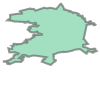

In [58]:
spb_polygon = wkt.load(open("./data/spb_polygon.txt"))
spb_polygon

In [59]:
all_locations["in_spb"] = all_locations["poly_center"].apply(lambda x: spb_polygon.contains(wkt.loads(x))).astype(int)

In [60]:
all_locations.head()

,point,poly_center,in_spb
0,0,POINT (0.0000000000 0.0000000000),0
1,1,POINT (30.1160199001 59.8357054295),1
2,2,POINT (30.2485214045 59.9292365030),1
3,3,POINT (30.2485214045 59.9708463091),1
4,4,POINT (30.2485214045 60.0236267278),1


In [77]:
all_locations.to_csv("./data/all_locations.csv", index=None)

In [67]:
all_locations["point"] = all_locations["point"].astype(int)

In [68]:
print(f"Number of locations {len(all_locations)} - Number of spb locations {all_locations.in_spb.sum()}")

Number of locations 7041 - Number of spb locations 6796


In [69]:
train_df = optimize_memory(train_df.merge(
    all_locations[["point", "in_spb"]], how="left", left_on="point", right_on="point"
))

Memory usage 520.42 MB -> 415.01 MB (-20.3%)


In [70]:
train_df.isnull().sum()

timestamp        0
lon              0
lat              0
likescount       0
commentscount    0
symbols_cnt      0
words_cnt        0
hashtags_cnt     0
mentions_cnt     0
links_cnt        0
emoji_cnt        0
point            0
poly_center      0
in_spb           0
dtype: int64

In [71]:
train_df.shape

(8526526, 14)

In [72]:
train_df = train_df[train_df["in_spb"] == 1]

In [73]:
train_df.shape

(8289018, 14)

In [74]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,poly_center,in_spb
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,6037,POINT (30.3293697801 59.9404875478),1
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,2362,POINT (30.3428445093 59.8695422185),1
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,4343,POINT (30.3226324155 60.0393322825),1
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,4354,POINT (30.3226324155 59.9382376441),1
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,1027,POINT (30.3091576862 59.9326122172),1


In [78]:
train_df.drop(columns=["poly_center"], inplace=True)

In [79]:
train_df.to_csv("./data/wip_train.csv", index=None)

# Group by main-features and decrease size of dataset

In [80]:
train_df = optimize_memory(pd.read_csv("./data/wip_train.csv"))

Memory usage 822.12 MB -> 324.11 MB (-60.6%)


In [81]:
feature_columns = [
    "likescount",
    "commentscount",
    "symbols_cnt",
    "words_cnt",
    "hashtags_cnt",
    "mentions_cnt",
    "links_cnt",
    "emoji_cnt",
]
feature_aggregate_methods = [np.mean, np.std]

In [82]:
simple_posts_features_df = optimize_memory(
    train_df.groupby(["point", "timestamp"], as_index=False).aggregate(
        { feature: feature_aggregate_methods for feature in feature_columns }
    )
)
simple_posts_features_df.fillna(0, inplace=True)
simple_posts_features_df.head(100)

Memory usage 453.68 MB -> 453.68 MB (-0.0%)


point   timestamp likescount      commentscount      symbols_cnt       \
                           mean  std          mean  std        mean  std   
0      1  1574420400       31.0  0.0           3.0  0.0       270.0  0.0   
1      1  1574424000       37.0  0.0           4.0  0.0       358.0  0.0   
2      1  1574514000       34.0  0.0           0.0  0.0       119.0  0.0   
3      1  1574697600       45.0  0.0           2.0  0.0       244.0  0.0   
4      1  1574848800       42.0  0.0           2.0  0.0       242.0  0.0   
..   ...         ...        ...  ...           ...  ...         ...  ...   
95     3  1567846800        6.0  0.0           0.0  0.0       304.0  0.0   
96     3  1567868400       43.0  0.0           4.0  0.0        21.0  0.0   
97     3  1567875600       60.0  0.0           9.0  0.0       188.0  0.0   
98     3  1567922400       56.0  0.0           8.0  0.0      1904.0  0.0   
99     3  1567944000        7.0  0.0           0.0  0.0        43.0  0.0   

   words_cnt      hashtags_cnt      mentions_cnt      links_cnt       \
        mean  std         mean  std         mean  std      mean  std   
0       24.0  0.0          5.0  0.0          1.0  0.0       0.0  0.0   
1       31.0  0.0          4.0  0.0          0.0  0.0       0.0  0.0   
2        7.0  0.0          4.0  0.0          0.0  0.0       0.0  0.0   
3       16.0  0.0          4.0  0.0          1.0  0.0       0.0  0.0   
4       18.0  0.0          4.0  0.0          0.0  0.0       0.0  0.0   
..       ...  ...          ...  ...          ...  ...       ...  ...   
95       0.0  0.0         28.0  0.0          0.0  0.0       0.0  0.0   
96       0.0  0.0          2.0  0.0          0.0  0.0       0.0  0.0   
97      12.0  0.0          5.0  0.0          0.0  0.0       0.0  0.0   
98     188.0  0.0          0.0  0.0          0.0  0.0       0.0  0.0   
99       3.0  0.0          0.0  0.0          0.0  0.0       0.0  0.0   

   emoji_cnt       
        mean  std  
0        0.0  0.0  
1        1.0  0.0  
2        0.0  0.0  
3        0.0  0.0  
4        1.0  0.0  
..       ...  ...  
95       0.0  0.0  
96       0.0  0.0  
97       6.0  0.0  
98      10.0  0.0  
99       0.0  0.0  

[100 rows x 18 columns]

In [86]:
simple_posts_features_df.to_csv("./data/simple_features.csv", index=None)

# Add target values

In [83]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,in_spb
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,6037,1
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,2362,1
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,4343,1
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,4354,1
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,1027,1


In [84]:
train_df["count"] = 1
posts_count_df = optimize_memory(
    train_df[["point", "timestamp", "count"]].groupby(["point", "timestamp"], as_index=False).count()
)

Memory usage 47.40 MB -> 27.09 MB (-42.9%)


In [85]:
posts_count_df.head(100)

,point,timestamp,count
0,1,1574420400,1
1,1,1574424000,1
2,1,1574514000,1
3,1,1574697600,1
4,1,1574848800,1
...,...,...,...
95,3,1567846800,1
96,3,1567868400,1
97,3,1567875600,1
98,3,1567922400,1


In [87]:
posts_count_df.to_csv("./data/target.csv", index=None)

# Create composed features dataset

In [ ]:
# Cell's below don't work!

In [8]:
size = 0.25 # wild guess
spb_lon, spb_lat = 30.3141, 59.9386 # Spb coords
df = df_initial[(df_initial["lon"] <= spb_lon + size / 2.0) & (df_initial["lon"] >= spb_lon - size / 2.0) &
                (df_initial["lat"] <= spb_lat + size / 2.0) & (df_initial["lat"] >= spb_lat - size / 2.0)]

In [9]:
df["count"] = 1
df = df.groupby(["lon", "lat", "timestamp"]).agg({
    "count": np.sum,
    "likescount": np.mean,
    "commentscount": np.mean,
    "symbols_cnt": np.mean,
    "words_cnt": np.mean,
    "hashtags_cnt": np.mean,
    "mentions_cnt": np.mean,
    "links_cnt": np.mean,
    "emoji_cnt": np.mean,
}).reset_index()

/tmp/ipykernel_5521/1201879296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = 1


In [10]:
df.head()

,lon,lat,timestamp,count,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
0,30.190131,59.848116,431127,1,30.0,2.0,36.0,3.0,0.0,0.0,0.0,3.0
1,30.190131,59.848116,431422,1,7.0,0.0,256.0,0.0,12.0,0.0,0.0,0.0
2,30.190131,59.848116,431491,1,22.0,0.0,522.0,0.0,28.0,0.0,0.0,0.0
3,30.190131,59.848116,431955,1,16.0,3.0,60.0,0.0,4.0,0.0,0.0,0.0
4,30.190131,59.848116,432821,1,30.0,1.0,618.0,36.0,30.0,0.0,0.0,0.0


In [11]:
df.head()

,lon,lat,timestamp,count,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
0,30.190131,59.848116,431127,1,30.0,2.0,36.0,3.0,0.0,0.0,0.0,3.0
1,30.190131,59.848116,431422,1,7.0,0.0,256.0,0.0,12.0,0.0,0.0,0.0
2,30.190131,59.848116,431491,1,22.0,0.0,522.0,0.0,28.0,0.0,0.0,0.0
3,30.190131,59.848116,431955,1,16.0,3.0,60.0,0.0,4.0,0.0,0.0,0.0
4,30.190131,59.848116,432821,1,30.0,1.0,618.0,36.0,30.0,0.0,0.0,0.0


In [12]:
unique_lon = df.lon.unique()
unique_lat = df.lat.unique()
unique_timestamp = df.timestamp.unique()

In [13]:
len(unique_lon), len(unique_lat), len(unique_timestamp) # from 1 Feb 2019 to 1 Jan 2020 - 356 days * 24 = 9504

(111, 196, 9504)

In [1]:
cartesian_prod_lon_lat = list(map(list, zip(*itertools.product(unique_lon, unique_lat, unique_timestamp))))

NameError: name 'itertools' is not defined

In [ ]:
df_full = pd.DataFrame({"lon": cartesian_prod_lon_lat[0], "lat":cartesian_prod_lon_lat[1], "timestamp":cartesian_prod_lon_lat[2]})
df_full.head()

In [ ]:
df_full = pd.merge(df_full, df, on=["lon", "lat", "timestamp"], how="outer")
df_full.head()

In [ ]:
df_full.fillna(0, inplace=True)

In [ ]:
df_full[df_full.columns[~df_full.columns.isin(["lon","lat"])]] = df_full[df_full.columns[~df_full.columns.isin(["lon","lat"])]].astype("int64")

In [ ]:
df_full["hour"] = df_full.timestamp % 24

In [ ]:
df_with_features = pd.get_dummies(df_full, prefix="hour", columns=["hour"])
df_with_features.head()

In [ ]:
df_with_features.to_csv("./data/processed_data.csv", index=False)